# Parallel Computing 1: iPyParallel
    Name

In [1]:
from ipyparallel import Client
import numpy as np
import time
from matplotlib import pyplot as plt
from scipy import stats
from timeit import default_timer as time

In [4]:
%matplotlib inline

## Problem 1
Initializes a `Client` object, create a `DirectView` with all available engines, and import `scipy.sparse` as `sparse` on all engines.

(This is just to make sure your cluster is running and connected correctly)

In [5]:
# terminal command:
# ipcluster start --n 4

# initialize client
client = Client()
print('client ids', client.ids)

# create directview
dview = client[:]

# import scipy.sparse as sparse
dview.execute("import scipy.sparse as sparse")

client ids [0, 1, 2, 3]


<AsyncResult: execute>

## Problem 2

Write a function `variables(dx)` that accepts a dictionary of variables.
Distribute the variables to all engines, then pull the variables back.

In [9]:
def variables(dx):
    """
    input: dictionary of variables
    
    tasks: push variables to all engines
           (from the problem 1 client)
           pull variables back and check them
               against the original dictionary
    """

    # push variables to engines
    dview.push(dx)
    
    # check that all variables match
    for key, val in dx.items():
        pulled_values = dview.pull(key)
        assert all([ pulled_value == val for pulled_value in pulled_values ])
        
    

In [10]:
# run something to check your function
dx = {
    'a': 1,
    'b': 2
}

variables(dx)

## Problem 3

Write a function that accepts an integer n.
Instruct each engine to make n draws from the standard normal distribution, then hand back the minimum, maximum, and mean draw to the client.
Print the results.

In [6]:
# import
dview.execute('from scipy import stats')

# function that performs the sampling
def draw_n(n):
    gaussian = stats.norm()
    sample = gaussian.rvs(n)
    return sample.min(), sample.max(), sample.mean()

def draw_statistics(n):
    """
    input: integer n
    
    tasks: each engine makes n draws from 
            standard normal distribution
           compute the min, max, and mean for
            each engine
           print the resulting lists of mins,
            maxs, and means
    """
    
    # sample n values from gaussian on each engine
    result = np.array(dview.apply(draw_n, n))
    mins = list(result[:, 0])
    maxs = list(result[:, 1])
    means = list(result[:, 2])
    
    # print results
    print(f'means = {mins}')
    print(f'means = {maxs}')
    print(f'means = {means}')

In [10]:
# run something to check your function
draw_statistics(4)

means = [-1.3937797362319866, -1.5949202178259214, -0.7367148649193946, -0.7357638855001175]
means = [1.897242695229939, 0.8468418671431098, 1.6972472621814312, 0.36396822256126066]
means = [0.08794977732867987, -0.32060874854684496, 0.19926393812507487, -0.22371540709162252]


## Problem 4

Use `draw_statistics()` to compare serial and parallel execution times.
For $n = 1000000, 5000000, 10000000, 15000000,$
1. Time how long it takes to run your function.
2. Time how long it takes to do the same process (make n draws and calculate and record the statistics) in a for loop with $N$ iterations, where $N$ is the number of engines running.

Plot the execution times against $n$.
You should notice an increase in efficiency in the parallel
version as the problem size increases.

means = [-4.756573950003403, -4.811286847932534, -4.713286868390572, -4.9197711249782525]
means = [4.674500348173442, 5.037214686049491, 5.006800154840593, 4.944135648471994]
means = [-2.6746308640629887e-05, 0.0008628797214614647, -0.0018504985861485578, -0.001363402037850289]
means = [-5.24530005966757, -5.158035508320063, -5.000021673155456, -5.26134573162381]
means = [5.554972746260507, 5.269789106164695, 5.301297585827836, 5.511209156072071]
means = [-0.00012077616520526853, 0.000716990238168801, -3.328199768431283e-05, 9.342890336955942e-05]
means = [-5.187167985925468, -5.674611312953256, -5.576047369311147, -5.252370391393632]
means = [5.468087863627042, 5.082710364599715, 5.330349479256923, 4.976416964589305]
means = [0.00025317668783022857, -0.00033333398800125807, -0.00024004113412652033, -0.00019020927171563404]
means = [-5.457167774145261, -5.199102487376242, -5.378291527499133, -5.174984672982531]
means = [5.195146386148749, 5.437392400967747, 5.38781354369146, 5.54849072

Text(0, 0.5, 'Time')

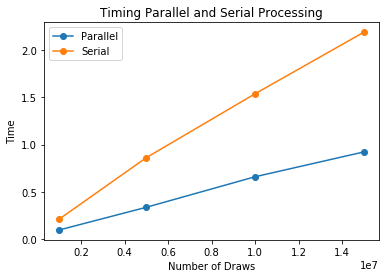

In [11]:
# prepare to store times
parallel_times = []
serial_times   = []
num_engines = len(dview.targets)

# for each n value
n_vals = np.array([1, 5, 10, 15]) * 1_000_000
for n in n_vals:
    
    # time parallel
    start = time()
    draw_statistics(n)
    parallel_times.append( time() - start )
    
    # time serial
    start = time()
    for _ in range(num_engines):
        draw_n(n)
    serial_times.append( time() - start )

# plot the two lists of times
plt.plot(n_vals, parallel_times, '-o', label='Parallel')
plt.plot(n_vals, serial_times, '-o', label='Serial')
plt.title('Timing Parallel and Serial Processing')
plt.legend()
plt.xlabel('Number of Draws')
plt.ylabel('Time')

## Problem 5

Write a function that accepts a function handle $f$ to integrate, bounds of integration, and the number of points to use for the approximation.
Parallelize the trapezoid rule in order to estimate the integral of $f$ over the given bounds.
That is, evenly divide the points among all available processors and run the trapezoid rule on each portion simultaneously.
The sum of the results of all the processors will be the estimation of the integral over the entire interval of integration.
Return this sum.

Demonstrate that your function works.

In [118]:
dview.execute('import numpy as np')

def trapezoid_parallel(f, a, b, N):
    """
    inputs: f = func to integrate
            a,b = integration bounds
            N = number of points used
    tasks:  estimate integral of f
    """
    
    def mini_trap(args):
        """Evaluate one term of the sum: f(x_0) + f(x_1)"""
        x_0, x_1 = args
        return f(x_0) + f(x_1)
    
    # get step size
    h = (b - a) / N
    
    # compute a list of steps and divide into tuples
    x = np.linspace(a, b, N)
    point_pairs = [(x[i - 1], x[i],) for i in range(1, len(x))]
    
    # evaluate the trapezoid rule on result
    return (h / 2) * np.array(dview.map_sync(mini_trap, point_pairs)).sum()
    


In [119]:

# test f
f = lambda x: np.sin(x) + 4
a,b = 1,4
N = 40

# evaluate integral using your function
print('estimated integral:',trapezoid_parallel(f,a,b,N))

# compare to scipy result
import scipy.integrate as integrate
print('actual integral:',integrate.quad(f,a,b)[0])

estimated integral: 12.863523209481984
actual integral: 13.193945926731752


In [66]:
[1, 2, 3, 4, 5][1:-1]

[2, 3, 4]